# Setup

The necessary imports and a simple function to plot histograms

In [2]:
import os
import matplotlib.pyplot as plt

from mlinspect.inspections.histogram_inspection import HistogramInspection
from mlinspect.checks.no_bias_introduced_for_constraint import NoBiasIntroducedForConstraint
from mlinspect.checks.no_illegal_features_constraint import NoIllegalFeaturesConstraint
from mlinspect.checks.check import Check
from demo.healthcare.no_missing_embeddings_constraint import NoMissingEmbeddingsConstraint
from mlinspect.inspections.lineage_inspection import LineageInspection
from mlinspect.inspections.materialize_first_rows_inspection import MaterializeFirstRowsInspection
from mlinspect.pipeline_inspector import PipelineInspector
from mlinspect.visualisation import save_fig_to_path
from mlinspect.utils import get_project_root
from mlinspect.instrumentation.dag_node import OperatorType
import pandas as pd
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [3]:
def print_dag_operator_histograms(constraint_result, attribute):    
    print("{} histogram".format(attribute))
            
    plt.subplot(1, 2, 1)        
    before_output_race_group = constraint_result[attribute].before_map
    keys = [str(key) for key in before_output_race_group.keys()]
    plt.bar(keys, before_output_race_group.values())
    plt.gca().set_title("before")
   
    plt.subplot(1, 2, 2)
    after_output_race_group = constraint_result[attribute].after_map
    keys = [str(key) for key in after_output_race_group.keys()]
    plt.bar(keys, after_output_race_group.values())
    plt.gca().set_title("after")
    
    fig = plt.gcf()
    fig.set_size_inches(12, 4)
    plt.show()

# Task description

Operators like joins, selections and missing value imputaters can cause *data distribution issues*, which can heavily impact the performance of our model. Mlinspect helps with identifying such issues by offering an inspection to calculate historams for sensitive groups. Thanks to our annotation propagation, this works even if the group columns are projected out at some point (**Issue 2**). To automatically check for significant changes and compute the histograms, we used the `no_bias_introduced_for(...)` constraint.

We want to find out if preprocessing operations in this pipeline introduce bias and if so, which groups are effected.
The pipeline we want to analyse can be found using the path `os.path.join(str(get_project_root()), "example_pipelines", "healthcare", "healthcare.py")`. Its code:

```python
"""
An example pipeline
"""
import os

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from demo.healthcare.demo_utils import MyW2VTransformer, create_model
from mlinspect.utils import get_project_root

COUNTIES_OF_INTEREST = ['county2', 'county3']

# load input data sources
patients = pd.read_csv(os.path.join(str(get_project_root()), "example_pipelines", "healthcare",
                                    "healthcare_patients.csv"), na_values='?')
histories = pd.read_csv(os.path.join(str(get_project_root()), "example_pipelines", "healthcare",
                                     "healthcare_histories.csv"), na_values='?')

# combine input data into a single table
data = patients.merge(histories, on=['ssn'])

# compute mean complications per age group, append as column
complications = data.groupby('age_group').agg(mean_complications=('complications', 'mean'))

data = data.merge(complications, on=['age_group'])

# target variable: people with a high number of complications
data['label'] = data['complications'] > 1.2 * data['mean_complications']

# project data to a subset of attributes
data = data[['smoker', 'last_name', 'county', 'num_children', 'race', 'income', 'label']]

# filter data
data = data[data['county'].isin(COUNTIES_OF_INTEREST)]

# define the feature encoding of the data
impute_and_one_hot_encode = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('encode', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ])

featurisation = ColumnTransformer(transformers=[
    ("impute_and_one_hot_encode", impute_and_one_hot_encode, ['smoker', 'county', 'race']),
    ('word2vec', MyW2VTransformer(min_count=2), ['last_name']),
    ('numeric', StandardScaler(), ['num_children', 'income'])
])

# define the training pipeline for the model
neural_net = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1, verbose=0, input_dim=109)
pipeline = Pipeline([
    ('features', featurisation),
    ('learner', neural_net)])

# train-test split
train_data, test_data = train_test_split(data, random_state=0)
# model training
model = pipeline.fit(train_data, train_data['label'])
# model evaluation
print(model.score(test_data, test_data['label']))

```

 This is using a synthetic benchmark dataset we created. 

# Add inspections and execute the pipeline

The central entry point of mlinspect is the `PipelineInspector`. To use mlinspect, we use it and pass it the path to the runnable version of the example pipeline. Here, we have the example pipeline in a `.py` file. 

First, we define the check we want mlinspect to run. In this example, we only use 1 check to compute histograms of sensitive groups and verify operators cause no significant distribution changes.

Then, we execute the pipeline. Mlinspect returns a `InspectorResult`, which contains the output of our check. 

In [4]:
HEALTHCARE_FILE_PY = os.path.join(str(get_project_root()), "example_pipelines", "healthcare", "healthcare.py")

check = Check()\
    .no_bias_introduced_for(["age_group", "race"])\

inspector_result = PipelineInspector\
    .on_pipeline_from_py_file(HEALTHCARE_FILE_PY) \
    .add_check(check) \
    .execute()

inspection_results = inspector_result.inspection_to_annotations
check_result = inspector_result.check_to_check_results[check]

0.42465752363204956


### Did our check find issues?

Let us look at the `check_result` to see whether some constraints failed. We see that some constraints failed and investigate which ones. As all 3 failed, we will look into each result in detail.

In [23]:
print(check_result.status)
print("")
for constraint_result in check_result.constraint_results.values():
    print("{}: {}".format(constraint_result.constraint, constraint_result.status))

CheckStatus.SUCCESS

NoBiasIntroducedForConstraint((('race', 'sex'), 0.3)): ConstraintStatus.SUCCESS


# We can look at how histograms of sensitive groups change after different Dag nodes

Our check already filtered all operators that can cause data distribution issues. Now we will use the result to create list with all distribution changes and visualize them. Using this, we can investigate the changes of the different operators one at a time.

In [11]:
no_bias_introduced_result = check_result.constraint_results[NoBiasIntroducedForConstraint(["age_group", "race"])]

print("Dag nodes that could have changed the distribution:")
distribution_changes = []
for dag_node, distribution_change in no_bias_introduced_result.bias_distribution_change.items():
    print('\033[1m')
    print(dag_node.operator_type, dag_node.code_reference, dag_node.module, dag_node.description, '\033[0m')
    distribution_changes.append(distribution_change)
    for column, change_info in distribution_change.items():
        if not change_info.acceptable_change:
            print("Sensitive column '{}': \033[1mThe distribution changed too much!\033[0m".format(column))
        else:
            print("Sensitive column '{}': No distribution change above the test threshold.".format(column))

Dag nodes that could have changed the distribution:

OperatorType.JOIN CodeReference(lineno=25, col_offset=7, end_lineno=25, end_col_offset=44) ('pandas.core.frame', 'merge') on ['ssn'] 
Sensitive column 'age_group': No distribution change above the test threshold.
Sensitive column 'race': No distribution change above the test threshold.

OperatorType.JOIN CodeReference(lineno=30, col_offset=7, end_lineno=30, end_col_offset=50) ('pandas.core.frame', 'merge') on ['age_group'] 
Sensitive column 'age_group': No distribution change above the test threshold.
Sensitive column 'race': No distribution change above the test threshold.

OperatorType.SELECTION CodeReference(lineno=39, col_offset=7, end_lineno=39, end_col_offset=54) ('pandas.core.frame', '__getitem__', 'Selection') Select by series (indirectly using 'None') 
Sensitive column 'age_group': No distribution change above the test threshold.
Sensitive column 'race': The distribution changed too much!

OperatorType.TRANSFORMER CodeRefere

As we can see, the selection causes the check to fail because of the `race` attribute. Still, we will investigate all of the operator changes to see if there is something else our check may have missed because the change was slightly below the change threshold of the `NoBiasIntroducedForConstraint(["age_group", "race"])` (which can be configured by the user).

## Let's see how different operations might change proportions of groups in data

We start by looking at the first operator that could heavily change the proportion of groups in our data, the `.dropna()` selection. Then, ...

age_group histogram


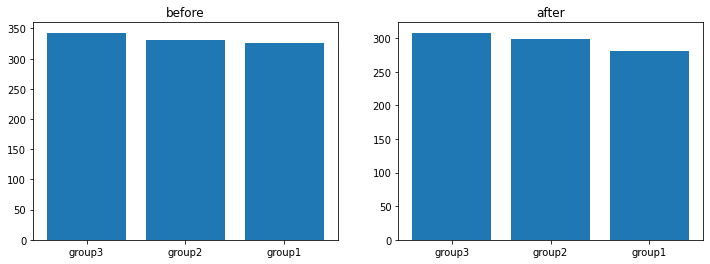

race histogram


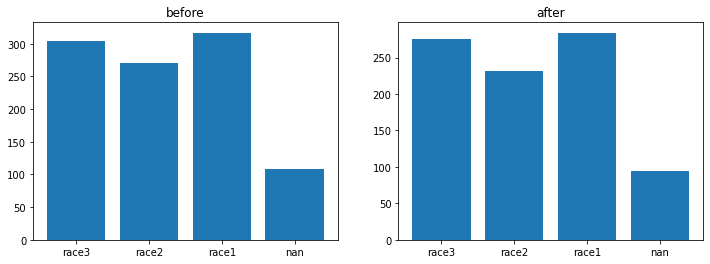

In [6]:
selection = distribution_changes[0]
print_dag_operator_histograms(selection, "age_group")
print_dag_operator_histograms(selection, "race")

**As we can see, there are no noteworthy changes because of the join.**

**The `most-frequent` imputation amplifies the existing `race` imbalance!**

# Solution: Did we find operators that introduce bias?

We conclude, gender bias can be found.